# Пример ML проекта

## Подключаемся к Google Drive

В реальном мире данные нужно брать из баз данных, но для учебных целей загрузим csv файл

In [1]:
import logging
import os
import shutil 

import numpy as np
from google.colab import drive
from IPython.display import Image

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)
logger.info('Подключили диск')

root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'ml-compling-2022-hse', 'data')
if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  logger.info('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

INFO:__main__:Инициализировали логгер
INFO:__main__:Подключили диск


Mounted at /content/drive


INFO:__main__:Содержимое директории /content/drive/MyDrive/ml-compling-2022-hse/data: ['client_segmentation.csv', 'boosting_toy_dataset.csv', 'ocr_dataset.zip', 'final_dataset.zip']


In [27]:
image_url_1 = 'https://raw.githubusercontent.com/aleksandr-dzhumurat/ml_intro_hse/4c2c85c47e54ffb6ba88be236ead2d5227010eb5/jupyter_notebooks/img/politic_meme.jpg'
image_url_2 = 'https://raw.githubusercontent.com/aleksandr-dzhumurat/ml_intro_hse/4c2c85c47e54ffb6ba88be236ead2d5227010eb5/jupyter_notebooks/img/two_level.png'

Каждая задача решается в несколько шагов
* Business Understanding
* Data understanding
* Baseline
* Modeling
* Production (релиз сервиса, в этом курсе этап с релизом не рассматриваем)

### Business Understanding

Сначала нужно пообщаться с бизнес-аналитиком, который расскажет про особенностями датасета:

Мы имеем дело с выгрузкой из системы модерации. Задача, которую мы решаем - предсказание того, будет ли контент "забанен". Бан контент может получить по разным причинам:

* расизм
* политика 
* кликбейт и т.д.

Пример контента, который получил бан по политическим причинам


В датасете 
* `content_id` - идентификатор контента, служебное поле
* `featured_approval_content_declined` - таргет, который мы предсказываем (`1` если контент был забанен и `0` в ином случае)
* `declined_reason` - причина бана (заполнено только для `content_declined==1`)

Остальные поля - фичи из различных источников
* статистические фичи
  * num_smiles
  * num_saves
  * num_shares
  * num_repubs
  * num_comments
  * num_days_on_service
* численные фичи
  * approved
  * soft_shotted
  * hard_shotted

In [ ]:
Image(url=image_url_1, width=300, height=400)

In [2]:
import pandas as pd

input_dataset_df = pd.read_csv(os.path.join(root_data_dir, 'final_dataset.zip'), compression='zip')

input_dataset_df.head()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,content_id,num_views,num_positve_actions,num_smiles,num_saves,num_shares,num_repubs,num_comments,num_days_on_service,featured_approval_content_declined,declined_reason,best_class,approved,hard_shotted,soft_shotted
0,IzpfrtD,127770,12725,12455,168,141,556,1784,25,0.0,NaN,NaN,NaN,NaN,NaN
1,FibDyiC,86090,6180,5704,173,383,289,6016,5,1.0,racism,approved,0.908444,0.033255,0.058302
2,LUkUBEm,78286,5228,4944,376,29,162,165,6,0.0,NaN,approved,0.994736,0.002517,0.002748
3,zPrfyiz,76931,5664,5506,231,8,151,395,5,1.0,politics_religion,approved,0.987415,0.008829,0.003755
4,eNAyJnh,72021,6148,5844,453,16,261,113,5,1.0,racism,approved,0.989974,0.005185,0.004841


Существующие фичи будут сильно расширены и дополнены в процессе фича-инжениринга

По примеру видно, что мощные фичи можно извлечь из текста (даже некоторые ключевые слова будут полезны как "фича" при детекции политических мемов)

Нам досутпна выгрузка из системы OCR (optical character recognition, оптическое распознавание символов), которая распознаёт текст на изображениях.

In [3]:
ocr_dataset_df = pd.read_csv(os.path.join(root_data_dir, 'ocr_dataset.zip'), compression='zip')

ocr_dataset_df.head()

,content_id,text
0,muTKNpX,Like this if you think Joe Biden\nshould to go...
1,oCsKxRF,This series is garbage.\nIt's so unrealistic
2,hEZuhDH,"Phone in one hand, your mum in the other\nidie..."
3,KuUnefc,vsauce.\nmichael here.\nyou cant contain me fo...
4,ykIaYzU,Fatphobia\nFatphobia is a phobia in which over...


Итого у нас два источника данных - посмотрим, что можно сделать с ними

## Data Understandig

Этот этап в анализе данные принято называть Exploratory Data Analysis (EDA)

На этом этапе нужно хорошо "закопаться" в данные  чтобы лучше понять их природу

Какие инструменты помогут

* **pandas** для работы с табличными данными
  * метод `.describe()` у датафрейма
  * `.merge()` для объединения различных источников данных
  * `.value_counts()` для быстрого выполнения операции `group by` + `count`
* визуализации с помощью методов `.plot()` и `.hist()` а также библиотеки matplotlib

In [4]:
input_dataset_df['num_positve_actions'].describe()

count    100000.000000
mean         52.511750
std         196.677364
min           4.000000
25%          17.000000
50%          22.000000
75%          35.000000
max       12725.000000
Name: num_positve_actions, dtype: float64

In [5]:
input_dataset_df.shape[0]

100000

In [6]:
input_dataset_df['featured_approval_content_declined'].value_counts()

0.0    71113
1.0    28887
Name: featured_approval_content_declined, dtype: int64

Начинаем генерить первые фичи

In [8]:
input_dataset_df['action_rate'] = (
  input_dataset_df['num_positve_actions'] / input_dataset_df['num_views']
)

input_dataset_df['action_rate'].describe()

count    100000.000000
mean          0.035188
std           0.010258
min           0.003347
25%           0.029167
50%           0.034296
75%           0.039693
max           0.209123
Name: action_rate, dtype: float64

Нормированные фичи всегда лучше чем ненормированные (но их лучше сглаживать)

Полезно проверить, есть ли разница в распределении фичей по таргету

<Axes: ylabel='Frequency'>

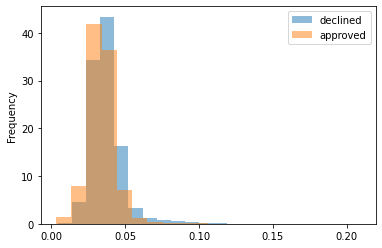

In [9]:
ax = input_dataset_df[
    input_dataset_df['featured_approval_content_declined']==1.0
]['action_rate'].plot(kind='hist', alpha=0.5, bins=20, label='declined', legend=True, density=True)

# xboxOne
input_dataset_df[
    input_dataset_df['featured_approval_content_declined']==0.0
]['action_rate'].plot(kind='hist', alpha=0.5, bins=20, label='approved', legend=True, density=True)

# Baseline

Когда данные достаточно поисследованы можно построить бейзлайн модель

Попробуем построить логистическую регрессию на текстах и проверить качество модели

Для начала трансформируем тексты в sparse матрицу

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer='word',
    lowercase=True,
    token_pattern=r'\b[\w\d]{3,}\b'
)

vectorizer.fit(ocr_dataset_df.text.values)

TfidfVectorizer(token_pattern='\\b[\\w\\d]{3,}\\b')

Ок, научились извлекать фичи из текста (подробнее поговорим об этом на следующем семинаре)

Разбиваем данные на тренировочный и тестовый сет.
* 70 x 30
* для обучения используем только текст

Разделяем данные на тренировочный и валидационный сет

In [11]:
from sklearn.model_selection import train_test_split

def split_dataset(source_df: pd.DataFrame, valid_train_set_size = 0.3):
  y = source_df.featured_approval_content_declined

  content_ids = source_df['content_id']

  x_train, x_test_ids, y_train, y_test = (
      train_test_split(
          content_ids, y, test_size=valid_train_set_size, random_state=RANDOM_SEED, stratify=y
      )
  )

  test_df = pd.DataFrame({'content_id': x_test_ids, 'y': y_test})
  train_df = pd.DataFrame({'content_id': x_train, 'y': y_train})
  logger.info('Positive target share %.4f', train_df['y'].value_counts(normalize=True)[1])

  return train_df, test_df

train_df, test_df = split_dataset(input_dataset_df)

train_df.head()

INFO:__main__:Positive target share 0.2889


,content_id,y
47861,rfxzrqU,0.0
24027,emQpiSp,0.0
80659,EEaGjjw,1.0
52290,EyNrMvA,1.0
45198,SkMuDjI,0.0


Проверяем, что сработала стратификация

In [12]:
train_df['y'].value_counts(normalize=True)

0.0    0.711129
1.0    0.288871
Name: y, dtype: float64

Трансформируем тренировочный датасет (для обучения) из текста в вектор

In [13]:
from scipy.sparse import csr_matrix

def prepare_tfidf(content_df, text_df, tfidf_vectorizer) -> csr_matrix:
  ocr_dataset_train = (
      content_df[['content_id']]
      .merge(text_df, how='left')
  )
  ocr_dataset_train.text.fillna('', inplace=True)
  ocr_features = tfidf_vectorizer.transform(ocr_dataset_train.text.values)

  return ocr_features

train_ocr_dataset = prepare_tfidf(train_df, ocr_dataset_df, vectorizer)

Обучаем модель

In [14]:
from sklearn.linear_model import LogisticRegression


log_reg = LogisticRegression(max_iter=500).fit(train_ocr_dataset, train_df['y'])
logger.info('Модель обучена')

INFO:__main__:Модель обучена


проверяем качество на тестовом датасете - считаем метрики

In [15]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, accuracy_score

test_ocr_dataset = prepare_tfidf(test_df, ocr_dataset_df, vectorizer)

predicted_classes = log_reg.predict(test_ocr_dataset)
logger.info(
    'Предсказания построены, accuracy = %.2f, f1_score = %.2f, recall_score = %.2f',
    accuracy_score(predicted_classes, test_df['y']),
    f1_score(predicted_classes, test_df['y']),
    recall_score(predicted_classes, test_df['y']),
)

INFO:__main__:Предсказания построены, accuracy = 0.75, f1_score = 0.39, recall_score = 0.69


получили очень низкое значение метрики, но т.к. бейзлайн то норм

# Modeling

На этом этапе мы будем генерировать фичи и проверят, как улучшается модель

## Улучшаем бейзлайн

### Определяем категории, где ошиблись сильнее всего

Этот трюк позволяет понять, какиех именно фичей не хватает в модели

Посмотрим на ошибку первого рода

In [16]:
false_negative_df = (
    pd.DataFrame({'pred': predicted_classes, 'ground_truth': test_df["y"]})
    .query("""(pred==0) and (ground_truth==1)""")
)

false_negative_df.head(5)

,pred,ground_truth
56312,0.0,1.0
68723,0.0,1.0
15476,0.0,1.0
10341,0.0,1.0
77778,0.0,1.0


In [17]:
prediction_df = (
    test_df
    .merge(input_dataset_df[['content_id', 'declined_reason']])
)
prediction_df['y_pred'] = predicted_classes

prediction_df.head()

,content_id,y,declined_reason,y_pred
0,eVJrFpd,0.0,NaN,0.0
1,jBbWeAa,1.0,nudity_censored_genitals,0.0
2,DAwoTDw,0.0,NaN,0.0
3,MGNTXRW,0.0,NaN,0.0
4,kkkswci,1.0,tragedy_death_gore_injuries,0.0


In [18]:
prediction_df.query("""(y_pred==0) and (y==1)""").sample(4)

,content_id,y,declined_reason,y_pred
3471,lVNDIvB,1.0,racism,0.0
22328,uJgzOjw,1.0,politics_religion,0.0
14752,pksTibn,1.0,not_safe_for_work,0.0
23210,VwwDUTR,1.0,not_safe_for_work,0.0


In [19]:
reason_accuracy = []
for reason in prediction_df.declined_reason.value_counts().keys().to_list():
  filtered_df = prediction_df[prediction_df['declined_reason']==reason]
  logger.info(
      '%s: rows %d, accuracy = %.2f, f1_score = %.2f',
      reason,
      filtered_df.shape[0],
      accuracy_score(filtered_df.y_pred, filtered_df.y),
      f1_score(filtered_df.y_pred, filtered_df.y),
  )
  reason_accuracy.append((reason, accuracy_score(filtered_df.y_pred, filtered_df.y)))

INFO:__main__:politics_religion: rows 3049, accuracy = 0.44, f1_score = 0.61
INFO:__main__:racism: rows 1122, accuracy = 0.25, f1_score = 0.40
INFO:__main__:lgbt_woman_jokes: rows 875, accuracy = 0.31, f1_score = 0.48
INFO:__main__:not_safe_for_work: rows 743, accuracy = 0.04, f1_score = 0.08
INFO:__main__:Political_Lite: rows 619, accuracy = 0.28, f1_score = 0.43
INFO:__main__:tragedy_death_gore_injuries: rows 555, accuracy = 0.12, f1_score = 0.21
INFO:__main__:watermark: rows 406, accuracy = 0.17, f1_score = 0.29
INFO:__main__:call_to_harm: rows 379, accuracy = 0.06, f1_score = 0.11
INFO:__main__:nudity_censored_genitals: rows 273, accuracy = 0.05, f1_score = 0.10
INFO:__main__:moderation_mistake: rows 179, accuracy = 0.09, f1_score = 0.17
INFO:__main__:clickbait: rows 138, accuracy = 0.06, f1_score = 0.11
INFO:__main__:pedo: rows 136, accuracy = 0.12, f1_score = 0.21
INFO:__main__:disabilities: rows 61, accuracy = 0.02, f1_score = 0.03
INFO:__main__:bodily_fluids: rows 58, accuracy 

В табличном виде неудобно смотреть, применяем визуализацию

<Axes: xlabel='reason'>

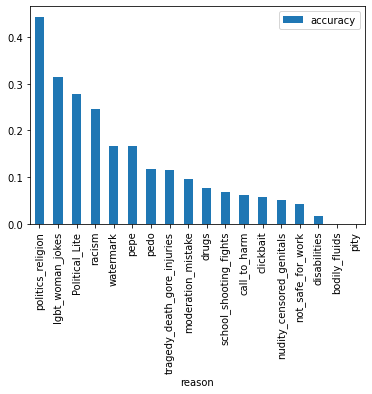

In [20]:
from operator import itemgetter

res =   (
    pd.DataFrame(
        sorted(reason_accuracy, key=itemgetter(1), reverse = True),
        columns=['reason', 'accuracy']
    )
)
res.plot(kind='bar', x='reason', y='accuracy')

Выявили категории, с которыми плохо справляется модель

* `nudity_censored_genitals`
* `school_shooting_fights`
* `not_safe_for_work`
* `bodily_fluids`
* `pity`

Скорее всего несколько категорий по тексту предсказывать не получится - для этих категорий нужны какие-то картиночные фичи. Поэтому для улучшения качества мы можем пока удалить эти категории из разметки, раз уже текущее пространство фичей не позволяет качественно детектировать эти категории.

In [21]:
non_prediction_declined_reason = [
    'nudity_censored_genitals', 'school_shooting_fights', 'not_safe_for_work', 'bodily_fluids', 'pity'
]

input_dataset_df.loc[
    input_dataset_df['declined_reason'].isin(non_prediction_declined_reason), 'featured_approval_content_declined'
] = 0.0

# т.к. таргет поменялся, нужно повторное разбиение
train_df, test_df = split_dataset(input_dataset_df)

train_df.head()

INFO:__main__:Positive target share 0.2499


,content_id,y
50644,FyGigPx,1.0
70612,hYWHmVI,1.0
36427,CnoRjMg,0.0
22337,fFtZzvp,0.0
61597,ngCAQkz,0.0


Прогоним ещё раз пайплайн

* трансформация текста
* пресказание
* проверка качества

In [22]:
train_ocr_dataset = prepare_tfidf(train_df, ocr_dataset_df, vectorizer)

test_ocr_dataset = prepare_tfidf(test_df, ocr_dataset_df, vectorizer)
log_reg = LogisticRegression(max_iter=500).fit(train_ocr_dataset, train_df['y'])

predicted_classes = log_reg.predict(test_ocr_dataset)
logger.info(
    'Предсказания построены, accuracy = %.2f, f1_score = %.2f, recall_score = %.2f',
    accuracy_score(predicted_classes, test_df.y),
    f1_score(predicted_classes, test_df.y),
    recall_score(predicted_classes, test_df.y),
)

INFO:__main__:Предсказания построены, accuracy = 0.79, f1_score = 0.40, recall_score = 0.71


Итого было
```
Предсказания построены, accuracy = 0.75, f1_score = 0.39, recall_score = 0.69
```

Стало
```
Предсказания построены, accuracy = 0.79, f1_score = 0.40, recall_score = 0.71
```

Мы увеличили качество модели, но это не совсем честное улучшение, т.к. мы просто перенеcли часть проблем в будущее (когда появится новые фичи)

### Улучшаем препроцессинг данных

Входные данные максимально влияют на качество алгоритма (вспоминаем принцип garbage in - garbage out).

Наши входные данные - результат tf-idf, давайте попробуем улучшить из за счет фильтрации "мусора" 

In [23]:
print(vectorizer.get_feature_names_out()[:10])

['000' '0000' '00000' '000000' '0000000' '000000000' '000000000133'
 '0000000h' '0000001650' '0000001750']


Видно, что входные данные достаточно "грязные" воспользуемся небольшой эвристикой для улучшения датасета

In [24]:
MIN_DOCS = 0.0001  # эвристика
better_vectorizer = TfidfVectorizer(analyzer='word', lowercase=True, token_pattern=r'\b[\w\d]{3,}\b', min_df=MIN_DOCS)

ocr_features = better_vectorizer.fit(ocr_dataset_df.text.values)

print(better_vectorizer.get_feature_names_out()[:10])

['000' '00000' '001' '006' '007' '008' '010' '014' '021' '022']


Кажется, данные стали более "чистыми". Проверим, как отреагировали метрики

In [25]:
train_ocr_dataset = prepare_tfidf(train_df, ocr_dataset_df, better_vectorizer)
log_reg = LogisticRegression(max_iter=500).fit(train_ocr_dataset, train_df['y'])

test_ocr_dataset = prepare_tfidf(test_df, ocr_dataset_df, better_vectorizer)

predicted_classes = log_reg.predict(test_ocr_dataset)
logger.info(
    'Предсказания построены, accuracy = %.2f, f1_score = %.2f, recall_score = %.2f',
    accuracy_score(predicted_classes, test_df.y),
    f1_score(predicted_classes, test_df.y),
    recall_score(predicted_classes, test_df.y),
)

INFO:__main__:Предсказания построены, accuracy = 0.79, f1_score = 0.42, recall_score = 0.70


Итого было
```
Предсказания построены, accuracy = 0.79, f1_score = 0.40, recall_score = 0.71
```

Стало
```
Предсказания построены, accuracy = 0.79, f1_score = 0.42, recall_score = 0.70
```

Отлично, удалось ещё немного улучшить качество.

Подбирать параметры трансформации данных с помощью эвристик не самая хаорошая затея, лучше всего подбирать параметры данных на кросс-валидации

### Строим более сложную модель

Итого у нас есть "слабая" модель которую хотим как-то улучшать. Из предыдущих лекций мы знаем, что наиболее сильная модель - это бустинг. Как с помощью бустинга улучшить результаты логистической регрегрессии? Можно построить двууровневую модель, такой приём называется стакинг (от англ. to stack)

* на первом уровне делаем предсказание
* на втором уровне используем предсказание как фичу

Для этого нужно разбить тренировочный сет ещё на две части: часть используем для обучения логической регрессии, часть для бустинга

Такая сложная схема нужна т.к. и логистическая регрессия, и бустинг обучаются на одном и том же таргете, поэтому если сначала обучить на всём датасете логистическую регрессию, а потом использовать её предсказания как вичу то получим т.н. лик в данных: ситуация, когда на этапе тренировки бустинга во входных данных уже будет присутствовать информация о таргете

In [28]:
Image(url=image_url_2, width=600, height=200)

In [29]:
def split_dataset_two_level(source_df: pd.DataFrame, valid_train_set_size = 0.3, boosting_train_set_size=0.6):
  y = source_df.featured_approval_content_declined

  content_ids = source_df['content_id']

  x_train, x_test_ids, y_train, y_test = (
      train_test_split(
          content_ids, y, test_size=valid_train_set_size, random_state=RANDOM_SEED, stratify=y
      )
  )

  x_train_logreg_ids, x_train_boosting_ids, y_train_logreg, y_train_boosting = (
      train_test_split(
          x_train, y_train, test_size=boosting_train_set_size, random_state=RANDOM_SEED, stratify=y_train
      )
  )

  test_df = pd.DataFrame({'content_id': x_test_ids, 'y': y_test})
  train_logreg_df = pd.DataFrame({'content_id': x_train_logreg_ids, 'y': y_train_logreg})
  train_boosting_df = pd.DataFrame({'content_id': x_train_boosting_ids, 'y': y_train_boosting})
  logger.info('Positive target share %.4f', train_df['y'].value_counts(normalize=True)[1])

  return train_logreg_df, train_boosting_df, test_df

train_logreg_df, train_boosting_df, test_df = split_dataset_two_level(input_dataset_df)

INFO:__main__:Positive target share 0.2499


Для тренировки логистической регрессии получается меньше данных, проверим как это отразится на качестве

In [30]:
train_ocr_dataset = prepare_tfidf(train_logreg_df, ocr_dataset_df, better_vectorizer)
log_reg = LogisticRegression(max_iter=500).fit(train_ocr_dataset, train_logreg_df['y'])

test_ocr_dataset = prepare_tfidf(test_df, ocr_dataset_df, better_vectorizer)

predicted_classes = log_reg.predict(test_ocr_dataset)
logger.info(
    'Предсказания построены, accuracy = %.2f, f1_score = %.2f, recall_score = %.2f',
    accuracy_score(predicted_classes, test_df.y),
    f1_score(predicted_classes, test_df.y),
    recall_score(predicted_classes, test_df.y),
)

INFO:__main__:Предсказания построены, accuracy = 0.78, f1_score = 0.36, recall_score = 0.68


Пока качество на тестовом датасете низкое - посмотрим, сможет ли бустинг исправить ситуацию

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

def prepare_boosting(content_df, wide_dataset, text_df, tfidf_vectorizer, log_reg):
  target = content_df['y']
  boosting_df = content_df.drop('y', axis=1)

  x_tfidf_train = prepare_tfidf(content_df, text_df, tfidf_vectorizer)

  boosting_df = (
      boosting_df
      .merge(wide_dataset, how='inner')
  )

  boosting_df['action_rate'] = (
        boosting_df['num_positve_actions'] / boosting_df['num_views']
  )
  boosting_df['comment_rate'] = (
          boosting_df['num_comments'] / boosting_df['num_views']
  )

  boosting_df['logreg_positive_proba'] = log_reg.predict_proba(x_tfidf_train)[:, 1]
  BOOSTING_COLUMNS = [
    'action_rate', 'comment_rate', 'logreg_positive_proba',
    'approved', 'hard_shotted', 'soft_shotted'
  ]

  # важная история про заполнение пропусков
  for col in BOOSTING_COLUMNS:
      try:
          logger.info(
              'in coll %s, %.5f NULL',
              col, boosting_df[col].isna().value_counts(normalize=True).loc[True]
          )
          boosting_df[col].fillna(value=0.0, inplace=True)
      except KeyError:
          pass

  return boosting_df[BOOSTING_COLUMNS], target

boosting_df, target = prepare_boosting(
    train_boosting_df, input_dataset_df, ocr_dataset_df, better_vectorizer, log_reg
)

gb_clf = GradientBoostingClassifier().fit(boosting_df, target)

INFO:__main__:in coll approved, 0.00188 NULL
INFO:__main__:in coll hard_shotted, 0.00188 NULL
INFO:__main__:in coll soft_shotted, 0.00188 NULL


Формируем тестовый датасет и проверяем качество модели

In [32]:
test_boosting_df, test_target = prepare_boosting(
    test_df, input_dataset_df, ocr_dataset_df, better_vectorizer, log_reg
)

predicted_classes = gb_clf.predict(test_boosting_df)

logger.info(
    'Предсказания построены, accuracy = %.2f, f1_score = %.2f, recall_score = %.2f',
    accuracy_score(predicted_classes, test_df.y),
    f1_score(predicted_classes, test_df.y),
    recall_score(predicted_classes, test_df.y),
)

INFO:__main__:in coll approved, 0.00147 NULL
INFO:__main__:in coll hard_shotted, 0.00147 NULL
INFO:__main__:in coll soft_shotted, 0.00147 NULL
INFO:__main__:Предсказания построены, accuracy = 0.79, f1_score = 0.43, recall_score = 0.64


Это лучшее качество которое получили на логистической регрессии

```
Предсказания построены, accuracy = 0.79, f1_score = 0.42, recall_score = 0.70
```

Для двухуровневой модели с бустингом
```
Предсказания построены, accuracy = 0.79, f1_score = 0.44, recall_score = 0.64
```

У нас незначительно "просел" recall зато увеличился F1-скор

Можно продолжать улучшать дальше:
* закопаться в `feature engineering`
* лучше очистить входные данные
* потюнить параметры моделей